## Identification of the most suitable neighborhood in Munich, Germany, for a new state-funded food delivery service

Import of all relevant libraries:

In [18]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Import of various demographic data per neighborhood from the official website of the city of Munich:

In [29]:
##Density data

col_d = ['Ausprägung', 'Jahr', 'Räumliche Gliederung','Basiswert 1', 'Basiswert 2']

den = pd.read_csv('https://www.opengov-muenchen.de/dataset/0be6dc92-9ca5-4ae9-8a08-ba4039f2a225/resource/3f4aea4c-a79a-4f5b-ab01-a6ad540449f0/download/indikatorenatlas1812bevoelkerungeinwohnerdichte.csv',
                 usecols = col_d)
den = den[den['Jahr'] == 2017].reset_index(drop = True)
den.drop(['Ausprägung', 'Jahr'], axis = 1, inplace = True)
den.columns = ['Neighborhood', 'Tot_Population', 'Surface']

##Employment data

col_e = ['Ausprägung', 'Jahr', 'Räumliche Gliederung','Basiswert 1', 'Basiswert 2']

empl = pd.read_csv('https://www.opengov-muenchen.de/dataset/d9da8e51-bd0a-4207-8486-2b4ce1e5dc69/resource/1f47ff92-01fa-41a2-bd01-26fbf9ce2401/download/indikatorenatlas1812arbeitsmarkterwerbsfaehigenquote.csv',
                  usecols = col_e)
empl = empl[(empl['Jahr'] == 2017) & (empl['Ausprägung'] == 'gesamt')].reset_index(drop = True)
empl.drop(['Ausprägung', 'Jahr'], axis = 1, inplace = True)
empl.columns = ['Neighborhood', 'Employable_Population', 'Tot_Population']

##Unemployment data

col_u =  ['Ausprägung', 'Jahr', 'Räumliche Gliederung','Basiswert 2']

unemp = pd.read_csv('https://www.opengov-muenchen.de/dataset/4bed747e-a771-4f0d-a3a7-8aa9f78c95f3/resource/0f0ea161-c152-41a0-87da-35c737b66923/download/indikatorenatlas1812arbeitsmarktarbeitslose.csv',
                   usecols = col_u)
unemp = unemp[(unemp['Jahr'] == 2016) & (unemp['Ausprägung'] == 'Deutsche')].reset_index(drop = True)
unemp.drop(['Ausprägung', 'Jahr'], axis = 1, inplace = True)
unemp.columns = ['Neighborhood', 'Unemployed_Population']


The ratio of the employed population is calculated by subtracting the absolute number of unemployed from the employable population and divide it by the total employable population of the area. This indicator is used to identify the areas where the vast majority of the population have an higher disposable income and might therefore spend on takeaway food:

In [89]:
join1 = pd.merge(unemp, empl, on='Neighborhood', how='inner')
join1['Net_Employed'] = (join1['Employable_Population'] - join1['Unemployed_Population']) / join1['Employable_Population']
join1.drop(['Unemployed_Population', 'Employable_Population','Tot_Population'], axis = 1, inplace = True)


A further indicator 'Population density' is computed:

In [106]:
pop_data = pd.merge(join1, den, on='Neighborhood', how='inner')
pop_data['Population_Density'] = pop_data['Tot_Population'] / pop_data['Surface']
pop_data.reset_index(drop = True, inplace = True)

pop_data['Neighborhood'] = pop_data['Neighborhood'].str.slice(3, 100)
pop_data['Neighborhood'].replace('dt München', 'City_Total', inplace=True)
pop_data['Neighborhood'] = pop_data['Neighborhood'].str.replace(' - ','-')

pop_data.head()

,Neighborhood,Net_Employed,Tot_Population,Surface,Population_Density
0,City_Total,0.965413,1526056,310.7,4911.670422
1,Altstadt-Lehel,0.979058,20926,3.1,6750.322581
2,Ludwigsvorstadt-Isarvorstadt,0.969140,51632,4.4,11734.545455
3,Maxvorstadt,0.974752,51311,4.3,11932.790698
4,Schwabing-West,0.974988,68265,4.4,15514.772727


To get an idea of the demographics per area, the dataframe are plotted

Since no table of the single neighborhoods with their geodata was available on the internet, the coordinates per postal code have been joined to the neighboorhod list:

In [56]:
#Latitude and longitude per postal code

head_c = ['Coordinates','Geoshape','City','PostalCode']
coord = pd.read_csv('Data/postalcodes_geodata.csv', sep = ';', names = head_c, skiprows = 1)

coord.drop('Geoshape', axis=1, inplace=True)

coord[['Latitude', 'Longitude']] = coord.Coordinates.str.split(",",expand=True,)

coord.drop(['Coordinates','City'], axis=1, inplace=True)

#Mapping between postal code and neighborhoods

!pip install lxml
pc = pd.read_html('https://www.muenchen.de/leben/service/postleitzahlen.html', header = 0)
pc = pc[0]

pc1 = pd.DataFrame(pc.Postleitzahl.str.split(',').tolist(), index=pc.Stadtteil).stack()
pc1 = pc1.reset_index([0, 'Stadtteil'])
pc1.columns = ['Neighborhood', 'PostalCode']


The neighborhood table and the coordinates table are then joined toghether to obtain a list of the Munich neighborhoods and their geodata:

In [155]:
pc1['PostalCode'] = pc1['PostalCode'].astype(str)
coord['PostalCode'] = coord['PostalCode'].astype(str)

muc_coord_data = pd.merge(pc1, coord, on='PostalCode', how='inner')
muc_coord_data.drop('PostalCode', axis = 1, inplace = True)

muc_coord_data['Latitude'] = muc_coord_data['Latitude'].astype(float)
muc_coord_data['Longitude'] = muc_coord_data['Longitude'].astype(float)

muc_coord_data['Neighborhood'].replace('Obergiesing', 'Obergiesing-Fasangarten', inplace=True)
muc_coord_data['Neighborhood'].replace('Thalkirchen-Obersendling-Fürstenried-Forstenried-Solln', 'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln', inplace=True)

muc_coord_data.head()

,Neighborhood,Latitude,Longitude
0,Allach-Untermenzing,48.217157,11.514948
1,Altstadt-Lehel,48.135964,11.572905
2,Au-Haidhausen,48.120434,11.587445
3,Aubing-Lochhausen-Langwied,48.145276,11.436811
4,Berg am Laim,48.121904,11.618299


Connenction to the Foursquare API is established:

In [58]:
CLIENT_ID = 'WOC403X2UHUSJ5C1PZS25YKXYZ5YHVFTES000TT2OBE2AELR' # your Foursquare ID
CLIENT_SECRET = 'URRV5WLH3ZG2FLG5YEWOZSR0GBOWOOYDM1FJQDWW1VYSXJKA' # your Foursquare Secret
VERSION = '20200506'

The venues data are retrieved for all neighborhoods through a function and saved to a dataframe:

In [112]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [118]:
muc_venues = getNearbyVenues(names=muc_coord_data['Neighborhood'],
                                   latitudes=muc_coord_data['Latitude'],
                                   longitudes=muc_coord_data['Longitude']
                                  )

Allach-Untermenzing
Altstadt-Lehel
Au-Haidhausen
Aubing-Lochhausen-Langwied
Berg am Laim
Bogenhausen
Feldmoching-Hasenbergl
Hadern
Laim
Sendling-Westpark
Ludwigsvorstadt-Isarvorstadt
Schwanthalerhöhe
Maxvorstadt
Milbertshofen-Am Hart
Moosach
Neuhausen-Nymphenburg
Obergiesing-Fasangarten
Ramersdorf-Perlach
Pasing-Obermenzing
Schwabing-Freimann
Schwabing-West
Sendling
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
Trudering-Riem
Untergiesing-Harlaching


From the list of all venues only restaurants are selected and counted for each neigborhood:

In [165]:
restaurants = muc_venues[muc_venues['Venue Category'].str.contains('estaurant')].reset_index(drop=True)
rest_count = restaurants.groupby(['Neighborhood']).size().reset_index(name='Count_Restaurants')


Finally both restaurant data and demographic data are joined into one table for comparison, only the columns relevant for the analysis are kept:

In [178]:
data_join = pd.merge(pop_data, rest_count, on='Neighborhood', how='outer')
data_join['Restaurant_Density'] = data_join['Count_Restaurants'] / data_join['Surface']
data_join['Pop_Rest_Ratio'] = data_join['Tot_Population'] / data_join['Count_Restaurants']

data_join = data_join.iloc[:, [0,1,2,4,6,7]]

data_join


,Neighborhood,Net_Employed,Tot_Population,Population_Density,Restaurant_Density,Pop_Rest_Ratio
0,Aubing-Lochhausen-Langwied,0.966578,46385,1360.263930,0.087977,15461.666667
1,Allach-Untermenzing,0.971685,32677,2108.193548,0.129032,16338.500000
2,Feldmoching-Hasenbergl,0.954726,60933,2108.408304,0.034602,60933.000000
3,Schwabing-Freimann,0.970747,76341,2970.466926,0.311284,9542.625000
4,Trudering-Riem,0.967386,72006,3200.266667,0.222222,14401.200000
5,Bogenhausen,0.973247,85971,3627.468354,1.645570,2204.384615
6,Pasing-Obermenzing,0.967508,74098,4490.787879,0.848485,5292.714286
7,Moosach,0.954673,53662,4834.414414,2.612613,1850.413793
8,City_Total,0.965413,1526056,4911.670422,NaN,NaN
9,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.969014,95554,5368.202247,0.786517,6825.285714


Text(0, 0.5, 'Neighborhood')

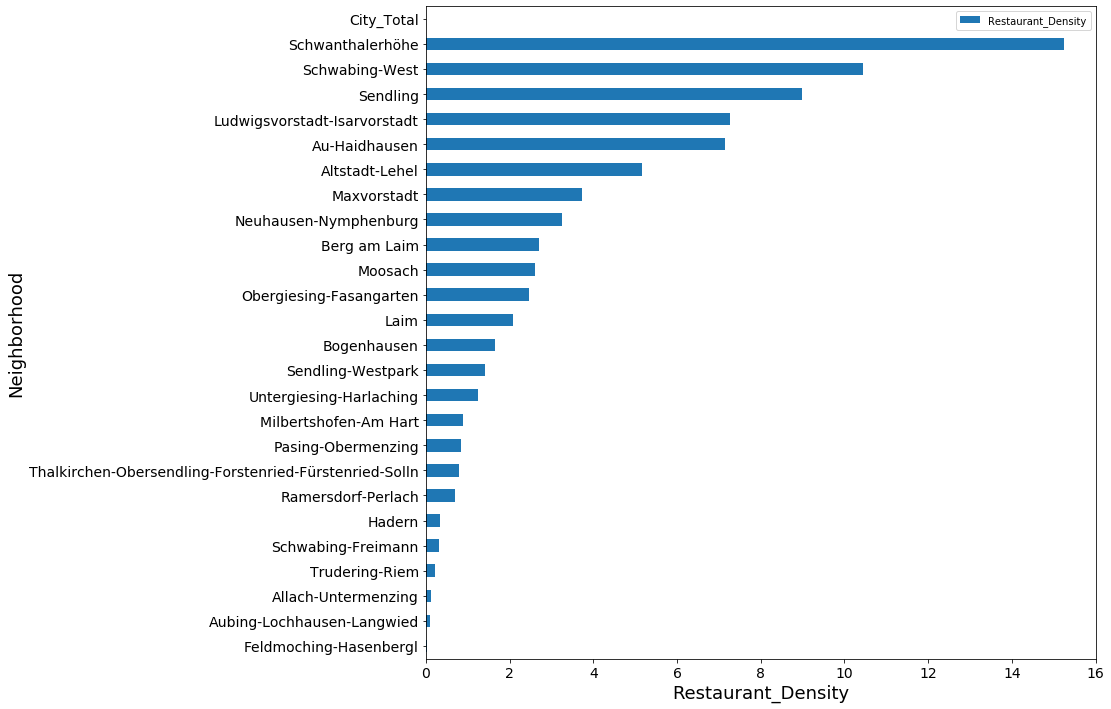

In [167]:
data_join.sort_values(['Restaurant_Density'], ascending = True, inplace = True)

plt = data_join.plot(x ='Neighborhood', y='Restaurant_Density', kind = 'barh', width=0.5, figsize=(12, 12), fontsize = 14)
plt.set_xlabel('Restaurant_Density', fontsize=18)
plt.set_ylabel('Neighborhood', fontsize=18)


For better interpretation of the data, the results are plotted into bar charts:

Text(0, 0.5, 'Neighborhood')

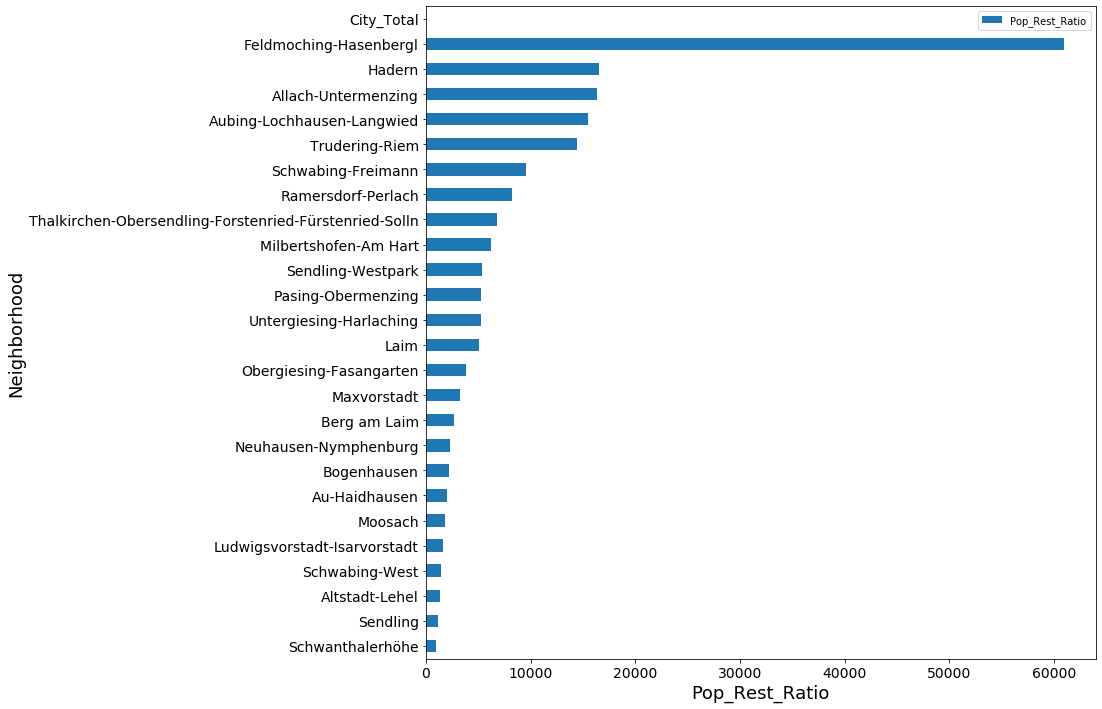

In [179]:
data_join.sort_values(['Pop_Rest_Ratio'], ascending = True, inplace = True)

plt = data_join.plot(x ='Neighborhood', y='Pop_Rest_Ratio', kind = 'barh', width=0.5, figsize=(12, 12), fontsize = 14)
plt.set_xlabel('Pop_Rest_Ratio', fontsize=18)
plt.set_ylabel('Neighborhood', fontsize=18)

Text(0, 0.5, 'Neighborhood')

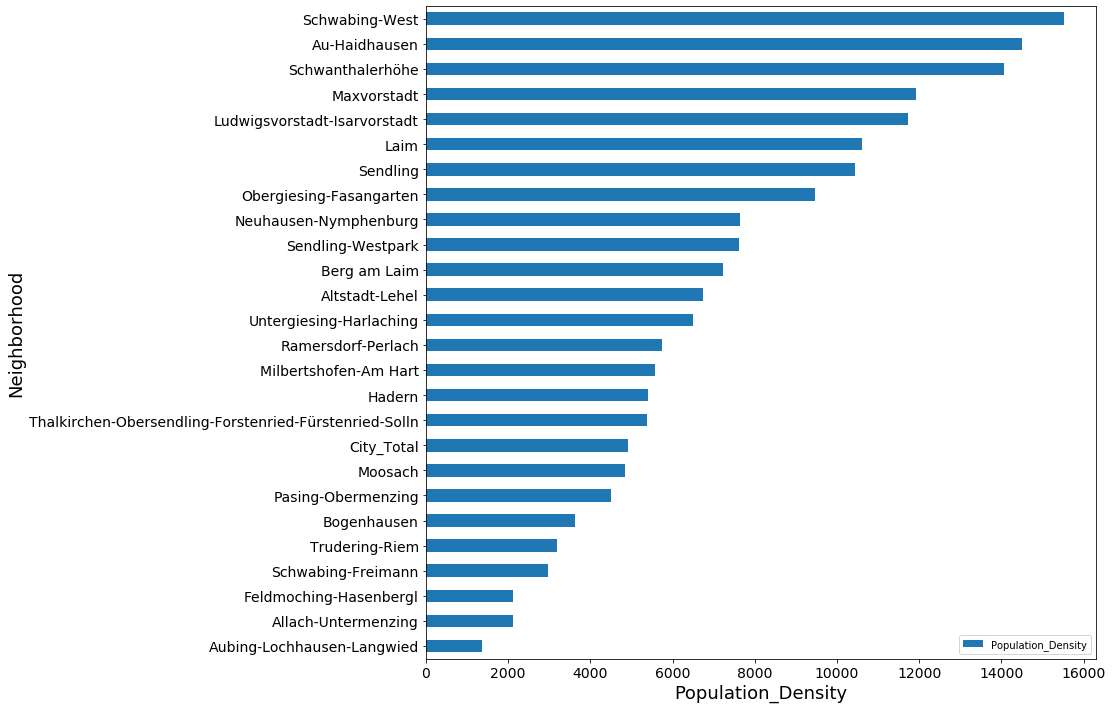

In [180]:
data_join.sort_values(['Population_Density'], ascending = True, inplace = True)

plt = data_join.plot(x ='Neighborhood', y='Population_Density', kind = 'barh', width=0.5, figsize=(12, 12), fontsize = 14)
plt.set_xlabel('Population_Density', fontsize=18)
plt.set_ylabel('Neighborhood', fontsize=18)

Text(0, 0.5, 'Neighborhood')

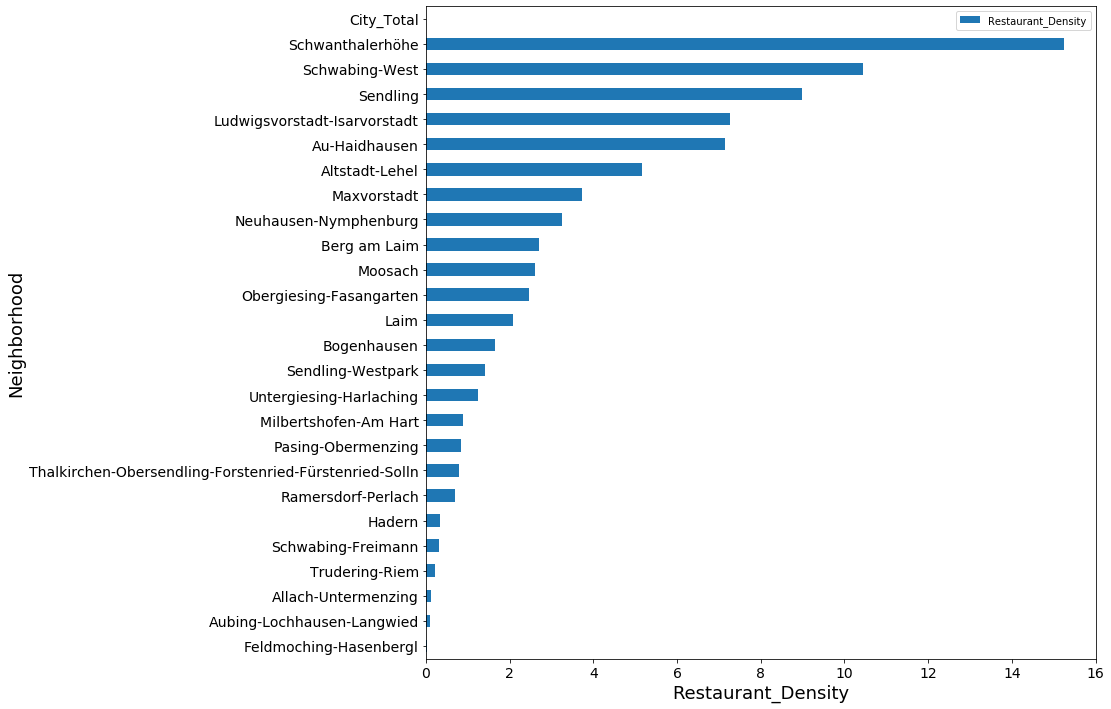

In [181]:
data_join.sort_values(['Restaurant_Density'], ascending = True, inplace = True)

plt = data_join.plot(x ='Neighborhood', y='Restaurant_Density', kind = 'barh', width=0.5, figsize=(12, 12), fontsize = 14)
plt.set_xlabel('Restaurant_Density', fontsize=18)
plt.set_ylabel('Neighborhood', fontsize=18)

(0.95, 0.98)

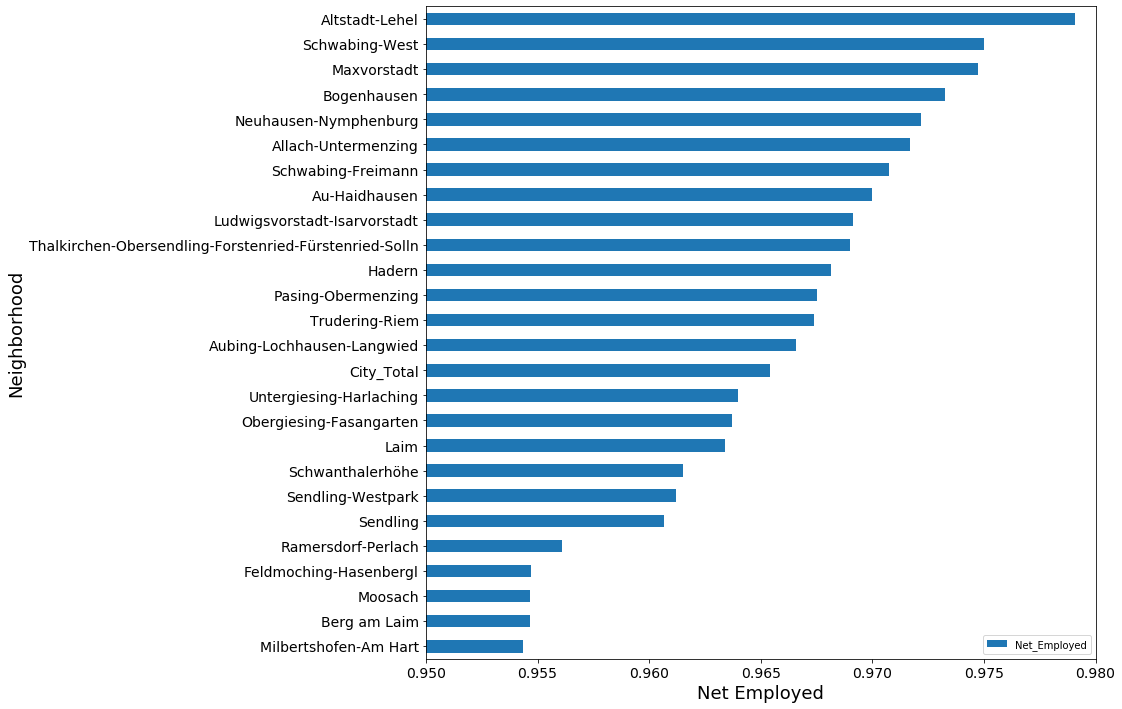

In [182]:
import pylab

pop_data.sort_values(['Net_Employed'], ascending = True, inplace = True)

plt = pop_data.plot(x ='Neighborhood', y='Net_Employed', kind = 'barh', width=0.5, figsize=(12, 12), fontsize = 14)
plt.set_xlabel('Net Employed', fontsize=18)
plt.set_ylabel('Neighborhood', fontsize=18)
pylab.xlim([0.95,0.98])

In [205]:
rest_density = data_join.sort_values(['Restaurant_Density'], ascending = False)
pop_density = data_join.sort_values(['Population_Density'], ascending = False)
NE = data_join.sort_values(['Net_Employed'], ascending = False)

rest_density.head()

,Neighborhood,Net_Employed,Tot_Population,Population_Density,Restaurant_Density,Pop_Rest_Ratio
23,Schwanthalerhöhe,0.961530,29535,14064.285714,15.238095,922.968750
25,Schwabing-West,0.974988,68265,15514.772727,10.454545,1484.021739
19,Sendling,0.960648,40682,10431.282051,8.974359,1162.342857
21,Ludwigsvorstadt-Isarvorstadt,0.969140,51632,11734.545455,7.272727,1613.500000
24,Au-Haidhausen,0.969969,60937,14508.809524,7.142857,2031.233333


In [206]:
pop_density.head()

,Neighborhood,Net_Employed,Tot_Population,Population_Density,Restaurant_Density,Pop_Rest_Ratio
25,Schwabing-West,0.974988,68265,15514.772727,10.454545,1484.021739
24,Au-Haidhausen,0.969969,60937,14508.809524,7.142857,2031.233333
23,Schwanthalerhöhe,0.961530,29535,14064.285714,15.238095,922.968750
22,Maxvorstadt,0.974752,51311,11932.790698,3.720930,3206.937500
21,Ludwigsvorstadt-Isarvorstadt,0.969140,51632,11734.545455,7.272727,1613.500000


In [197]:
NE.head()

,Neighborhood,Net_Employed,Tot_Population,Population_Density,Restaurant_Density,Pop_Rest_Ratio
14,Altstadt-Lehel,0.979058,20926,6750.322581,5.161290,1307.875000
25,Schwabing-West,0.974988,68265,15514.772727,10.454545,1484.021739
22,Maxvorstadt,0.974752,51311,11932.790698,3.720930,3206.937500
5,Bogenhausen,0.973247,85971,3627.468354,1.645570,2204.384615
17,Neuhausen-Nymphenburg,0.972166,98520,7637.209302,3.255814,2345.714286


In [210]:
Schwabing_west = data_join[(data_join['Neighborhood'] == 'Schwabing-West') | (data_join['Neighborhood'] == 'Au-Haidhausen') | (data_join['Neighborhood'] == 'Ludwigsvorstadt-Isarvorstadt')].reset_index(drop = True)
Schwabing_west


,Neighborhood,Net_Employed,Tot_Population,Population_Density,Restaurant_Density,Pop_Rest_Ratio
0,Au-Haidhausen,0.969969,60937,14508.809524,7.142857,2031.233333
1,Ludwigsvorstadt-Isarvorstadt,0.969140,51632,11734.545455,7.272727,1613.500000
2,Schwabing-West,0.974988,68265,15514.772727,10.454545,1484.021739
